In [124]:
import urllib3

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager

fontP = font_manager.FontProperties()
fontP.set_family('SimHei')
fontP.set_size(14)

beacon = []

with open("B23测试车场蓝牙坐标.txt") as f:
    data = f.readlines()
    index = 0
    for i in range(len(data)):
        data[i] = data[i].rstrip("\n")
        splits = data[i].split(',')
        #print(splits)
        if ( len(splits)<5 ):
            continue
        else:
            beacon.append(splits)
            
#print(beacon)
Beacon_xy = np.zeros((len(beacon),2))
for i in range(Beacon_xy.shape[0]):
    Beacon_xy[i,0] = beacon[i][3]
    Beacon_xy[i,1] = beacon[i][4]

In [131]:
import json

beacon_seq = []
compass_seq = []
accelerometer_seq = []
deviceMotion_seq = []
with open("beacon.log") as f:
    lines = f.readlines()
    #print(data)
    #json.loads(data[0])
    for line in lines:
        #print (line)
        try:
            res_sparse = json.loads(line[24:])
        #print (a)
        
        except Exception as e:
            continue
        beacon_response = []
        compass_samples = []
        accelerometer_samples = []
        deviceMotion_samples = []
        for res in res_sparse:
            #解析信标
            if res['type'] == 'ibeacon':
                for one_beacon in res['res']:
                    beacon_response.append(one_beacon)
            if res['type'] == 'compass':
                #解析罗盘
                compass_samples.append(res['res'])
            if res['type'] == 'accelerometer':
                #解析加速器
                accelerometer_samples.append(res['res'])
            if res['type'] == 'deviceMotion':
                #解析设备方向
                deviceMotion_samples.append(res['res'])
        beacon_seq.append(beacon_response)
        compass_seq.append(compass_samples)
        accelerometer_seq.append(accelerometer_samples)
        deviceMotion_seq.append(deviceMotion_samples)


In [179]:
import json
import time
#url = "http://114.55.32.219:18001/API/localization、"
url = "http://127.0.0.1:8000/API/localization/"
res_loc = [[0,0]]
kalmanFactor=[[0,0],[[0,0],[0,0]],200,200]
keys = ['res','timestamps','type']
with open("beacon.log") as f:
    lines = f.readlines()
    for line in lines[100:]:
        try:
            res_sparse = json.loads(line[24:])
        #print (a)
        
        except Exception as e:
            continue
        t = time.time()
        tmp1 = dict(zip(keys,[kalmanFactor,t,'last_kalman']))
        tmp2 = dict(zip(keys,[res_loc[-1],t,'last_loc']))
        
        #postdata = json.loads(line)
        postdata = res_sparse
        postdata.append(tmp1)
        postdata.append(tmp2)
        http = urllib3.PoolManager()
        response = http.request('POST',url,body = json.dumps(postdata).encode('utf-8'),headers={'Content-Type': 'application/json'})
        #response = urllib3.urlopen(requests)        
        print(beacon_seq[100])
        print(response.data)
        res = json.loads(response.data)
        if res['location']['x']>0:
            res_loc.append([res['location']['x'],res['location']['y']])
        kalmanFactor = [res['kalmanFactor']['evalkk'],res['kalmanFactor']['Pkk1'],res['kalmanFactor']['Q'],res['kalmanFactor']['R']] 
        break

[['a99bc9df-84ae-418c-bf7b-2dd963fe109f', 10000, 34055, -63, 0.018286347079897472], ['a99bc9df-84ae-418c-bf7b-2dd963fe109f', 10000, 34051, -66, 0.029117951573755272], ['a99bc9df-84ae-418c-bf7b-2dd963fe109f', 10000, 34054, -69, 0.045416364981985265], ['a99bc9df-84ae-418c-bf7b-2dd963fe109f', 10000, 34050, -69, 0.05054304722235554], ['a99bc9df-84ae-418c-bf7b-2dd963fe109f', 10000, 34054, -72, 0.06950986232378248], ['a99bc9df-84ae-418c-bf7b-2dd963fe109f', 10000, 34052, -79, 0.1757892757713928], ['a99bc9df-84ae-418c-bf7b-2dd963fe109f', 10000, 34041, -79, 0.1757892757713928], ['a99bc9df-84ae-418c-bf7b-2dd963fe109f', 10000, 34047, -83, 0.28807288880631093], ['a99bc9df-84ae-418c-bf7b-2dd963fe109f', 10000, 34041, -85, 0.36551964322715796], ['a99bc9df-84ae-418c-bf7b-2dd963fe109f', 10000, 34049, -88, 0.5754362750005042], ['a99bc9df-84ae-418c-bf7b-2dd963fe109f', 10000, 34043, -99, 2.0920487932032255]]
b'{"location": {"x": 29413.36217826646, "y": 10396.94584905347}, "kalmanFactor": {"evalkk": [[0, 0

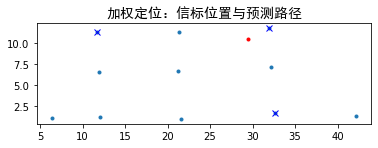

In [181]:
def Convert(lst):
    unpack = []
    for i in lst:
        unpack.extend(i)
    res_dct = {unpack[i]+'_'+unpack[i+1]+'_'+unpack[i+2]: unpack[i+3:i+5] for i in range(0, len(unpack), 5)}
    return res_dct
def GetXY(dct,uid):
    try:
        XY = dct[uid]
        return [float(i) for i in XY]
    except KeyError:
        return -1
# 将step按RSS排序
def takeRSS(elem):
    return elem[3]
beacon_dic = Convert(beacon)
cur_step = []
for one_beacon in beacon_seq[50]:
    if GetXY(beacon_dic,one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2])) != -1 :
        cur_step.append(one_beacon)
#cur_step = beacon_seq[100]
cur_step.sort(key=takeRSS,reverse = True)
cur_step = cur_step[0:3]
distance = np.zeros(3)
points = np.ones((3,2))
points[0] = GetXY(beacon_dic,cur_step[0][0].lower()+'_'+str(cur_step[0][1])+'_'+str(cur_step[0][2]))
points[1] = GetXY(beacon_dic,cur_step[1][0].lower()+'_'+str(cur_step[1][1])+'_'+str(cur_step[1][2]))
points[2] = GetXY(beacon_dic,cur_step[2][0].lower()+'_'+str(cur_step[2][1])+'_'+str(cur_step[2][2]))
distance = np.zeros(3)
distance[0] = cur_step[0][4]
distance[1] = cur_step[1][4]
distance[2] = cur_step[2][4]
plt.figure(figsize=(6,6))
plt.title("加权定位：信标位置与预测路径", fontproperties=fontP)
res_loc_array = np.array(res_loc)
plt.plot(res_loc_array[1:,0]/1000,res_loc_array[1:,1]/1000,'r.')
plt.plot(Beacon_xy[:,0]/1000,Beacon_xy[:,1]/1000,'.')
plt.plot(points[:,0]/1000,points[:,1]/1000,'bx')
plt.gca().set_aspect(1)
plt.show()   

In [182]:
points/1000

array([[32.613,  1.767],
       [31.931, 11.736],
       [11.669, 11.291]])

In [183]:
distance

array([0.02035054, 0.02140529, 0.13602813])

In [184]:
res_loc_array[1:]/1000

array([[29.41336218, 10.39694585]])

In [185]:
def Distance2D(Array_point,location):
    if Array_point.shape[1] !=2 or location.shape[1] != 2:
        logger.info("不是二维点")
        return
    return np.array([np.sqrt((i[0]-location[0,0])**2 +(i[1]-location[0,1])**2)   for i in Array_point])  
Distance2D(points/1000,res_loc_array[1:]/1000)

array([ 9.20400171,  2.85159012, 17.76687147])

In [186]:
#上次位置，没有的话填默认
cur_step

[['a99bc9df-84ae-418c-bf7b-2dd963fe109f',
  10000,
  34050,
  -63,
  0.02035054334159614],
 ['a99bc9df-84ae-418c-bf7b-2dd963fe109f',
  10000,
  34046,
  -64,
  0.021405294326807753],
 ['a99bc9df-84ae-418c-bf7b-2dd963fe109f',
  10000,
  34054,
  -77,
  0.13602812622327007]]

In [180]:
beacon_seq[50]

[['a99bc9df-84ae-418c-bf7b-2dd963fe109f',
  10000,
  34046,
  -64,
  0.021405294326807753],
 ['a99bc9df-84ae-418c-bf7b-2dd963fe109f',
  10000,
  34054,
  -77,
  0.13602812622327007],
 ['a99bc9df-84ae-418c-bf7b-2dd963fe109f',
  10000,
  34042,
  -91,
  0.8046081692276548],
 ['a99bc9df-84ae-418c-bf7b-2dd963fe109f',
  10000,
  34050,
  -63,
  0.02035054334159614],
 ['a99bc9df-84ae-418c-bf7b-2dd963fe109f',
  10000,
  34055,
  -63,
  0.018286347079897472]]

In [22]:
try:
    a = 1/0
except Exception as e:
    print(e.args)

('division by zero',)
